## Abundance Analysis 

### Import Libraries and Install Dependencies

In [3]:
import sys
import subprocess
import pkg_resources

def install_missing_libraries():
    required_libraries = {
        'pandas': 'pandas',
        'numpy': 'numpy',
        'matplotlib': 'matplotlib',
        'seaborn': 'seaborn',
        'statsmodels': 'statsmodels'
    }
    
    installed_packages = {pkg.key for pkg in pkg_resources.working_set}
    missing_packages = []

    for lib, pip_name in required_libraries.items():
        if lib not in installed_packages:
            missing_packages.append(pip_name)
    
    if missing_packages:
        print(f"Installing missing packages: {', '.join(missing_packages)}")
        for package in missing_packages:
            try:
                subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
                print(f"Successfully installed {package}")
            except subprocess.CalledProcessError:
                print(f"Failed to install {package}")
    else:
        print("All required packages are already installed!")

# Run the installation check
if __name__ == "__main__":
    install_missing_libraries()

# Now import the required libraries
try:
    import os
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import statsmodels.api as sm
    print("All libraries successfully imported!")
except ImportError as e:
    print(f"Error importing libraries: {str(e)}")

/var/folders/w8/n6dl4vb96pxfg4ln03nqqq5m0000gp/T/ipykernel_33707/3736989358.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Installing missing packages: statsmodels
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 32.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 16.8 MB/s eta 0:00:00
All libraries successfully imported!


### Load the data

In [5]:
Fert = pd.read_csv("Combinedsp24_2_Fert_gottcha2.full.tsv", sep="\t")
FertSp = Fert[Fert['LEVEL'] == "species"]

NoFert = pd.read_csv("Combinedsp24_2_NoFert_gottcha2.full.tsv", sep="\t")
NoFertSp = NoFert[NoFert['LEVEL'] == "species"]

### Regression analysis

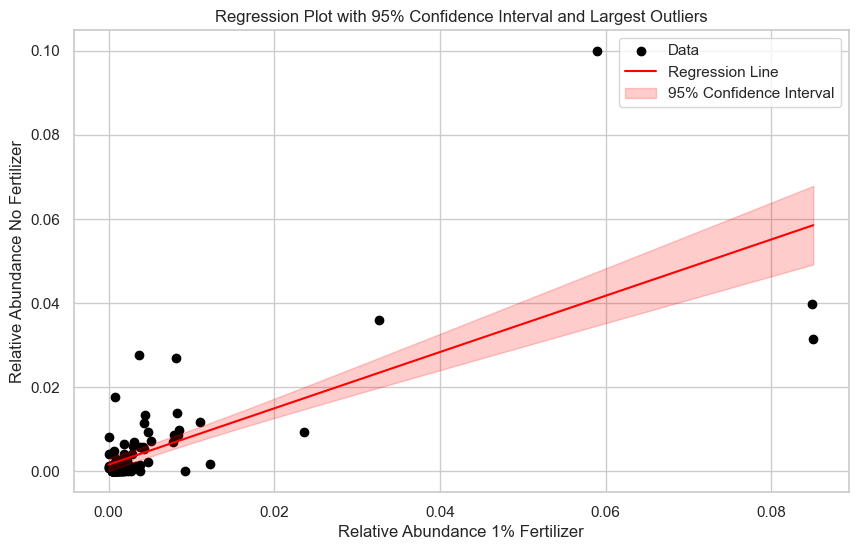

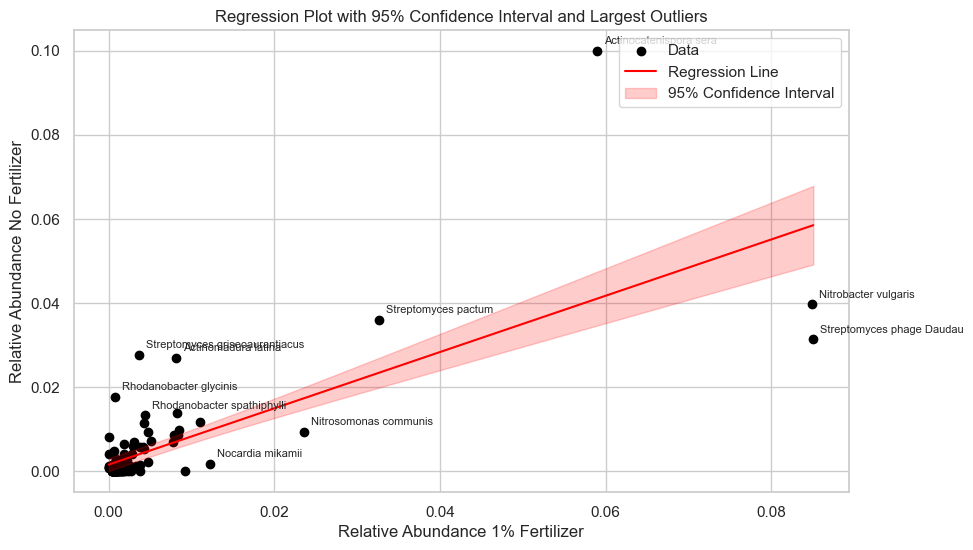

In [6]:
# Selecting columns
Fertspm = FertSp.iloc[:, [1, 9, 15, 16]]  # Adjust for zero-based index
NoFertspm = NoFertSp.iloc[:, [1, 9, 15, 16]]

# Merging data
Combined = pd.merge(Fertspm, NoFertspm, on="NAME", how="outer").fillna(0)

# Remove specific species
Combined = Combined[Combined['NAME'] != "Streptomyces griseofuscus"]

# Linear regression model
X = Combined['REL_ABUNDANCE_x']
y = Combined['REL_ABUNDANCE_y']
X_const = sm.add_constant(X)  # Add constant for intercept
model = sm.OLS(y, X_const).fit()

# Predict values and confidence intervals
x_values = np.linspace(X.min(), X.max(), 100)
x_values_const = sm.add_constant(x_values)
y_pred = model.predict(x_values_const)
predictions = model.get_prediction(x_values_const)
confidence_interval = predictions.conf_int(alpha=0.05)

# Calculate residuals
Combined['residual'] = y - model.predict(X_const)
Combined['abs_residual'] = Combined['residual'].abs()

# Get the 10 largest outliers
largest_outliers = Combined.nlargest(10, 'abs_residual')

# Plot
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot
ax.scatter(X, y, c='black', label="Data")

# Regression line
ax.plot(x_values, y_pred, color='red', label="Regression Line")

# Confidence interval
ax.fill_between(
    x_values,
    confidence_interval[:, 0],  # Lower bound
    confidence_interval[:, 1],  # Upper bound
    color='red',
    alpha=0.2,
    label="95% Confidence Interval"
)
# Customize plot
ax.set_xlabel("Relative Abundance 1% Fertilizer")
ax.set_ylabel("Relative Abundance No Fertilizer")
ax.set_title("Regression Plot with 95% Confidence Interval and Largest Outliers")
ax.legend()

plt.show()

# Improve plot by labeling the 10 greatest outliers
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot
ax.scatter(X, y, c='black', label="Data")

# Regression line
ax.plot(x_values, y_pred, color='red', label="Regression Line")

# Confidence interval
ax.fill_between(
    x_values,
    confidence_interval[:, 0],  # Lower bound
    confidence_interval[:, 1],  # Upper bound
    color='red',
    alpha=0.2,
    label="95% Confidence Interval"
)

# Label largest outliers
for _, row in largest_outliers.iterrows():
    ax.annotate(
        row['NAME'],  # Label to display
        (row['REL_ABUNDANCE_x'], row['REL_ABUNDANCE_y']),  # Position of the point
        fontsize=8,
        xytext=(5, 5),
        textcoords="offset points",
    )

# Customize plot
ax.set_xlabel("Relative Abundance 1% Fertilizer")
ax.set_ylabel("Relative Abundance No Fertilizer")
ax.set_title("Regression Plot with 95% Confidence Interval and Largest Outliers")
ax.legend()

# Show plot
plt.show()